1. Fully Convolutional 
    * https://arxiv.org/pdf/1609.07132.pdf
    * https://github.com/sthalles/cnn_denoiser
2. Wave U-Net
    * https://github.com/f90/Wave-U-Net-Pytorch/blob/master/waveunet.py
    * https://arxiv.org/pdf/1806.03185.pdf
3. RHR-Net
    * https://arxiv.org/ftp/arxiv/papers/1904/1904.07294.pdf

In [3]:
import librosa
import pandas as pd
import os
import datetime
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd
import librosa.display
import scipy
import glob
import numpy as np
import math
import warnings
import pickle
from sklearn.utils import shuffle

In [4]:
windowLength = 256
overlap      = round(0.25 * windowLength) # overlap of 75%
ffTLength    = windowLength
inputFs      = 48e3
fs           = 16e3
numFeatures  = ffTLength//2 + 1
numSegments  = 8
print("windowLength:",windowLength)
print("overlap:",overlap)
print("ffTLength:",ffTLength)
print("inputFs:",inputFs)
print("fs:",fs)
print("numFeatures:",numFeatures)
print("numSegments:",numSegments)

windowLength: 256
overlap: 64
ffTLength: 256
inputFs: 48000.0
fs: 16000.0
numFeatures: 129
numSegments: 8


In [5]:
def read_audio(filepath, sample_rate, normalize=True):
    # print(f"Reading: {filepath}").
    audio, sr = librosa.load(filepath, sr=sample_rate)
    if normalize:
      div_fac = 1 / np.max(np.abs(audio)) / 3.0
      audio = audio * div_fac
    return audio, sr
        
def add_noise_to_clean_audio(clean_audio, noise_signal):
    if len(clean_audio) >= len(noise_signal):
        # print("The noisy signal is smaller than the clean audio input. Duplicating the noise.")
        while len(clean_audio) >= len(noise_signal):
            noise_signal = np.append(noise_signal, noise_signal)

    ## Extract a noise segment from a random location in the noise file
    ind = np.random.randint(0, noise_signal.size - clean_audio.size)

    noiseSegment = noise_signal[ind: ind + clean_audio.size]

    speech_power = np.sum(clean_audio ** 2)
    noise_power = np.sum(noiseSegment ** 2)
    noisyAudio = clean_audio + np.sqrt(speech_power / noise_power) * noiseSegment
    return noisyAudio

def play(audio, sample_rate):
    ipd.display(ipd.Audio(data=audio, rate=sample_rate))  # load a local WAV file

In [6]:
class FeatureExtractor:
    def __init__(self, audio, *, windowLength, overlap, sample_rate):
        self.audio = audio
        self.ffT_length = windowLength
        self.window_length = windowLength
        self.overlap = overlap
        self.sample_rate = sample_rate
        self.window = scipy.signal.hamming(self.window_length, sym=False)

    def get_stft_spectrogram(self):
        return librosa.stft(self.audio, n_fft=self.ffT_length, win_length=self.window_length, hop_length=self.overlap,
                            window=self.window, center=True)

    def get_audio_from_stft_spectrogram(self, stft_features):
        return librosa.istft(stft_features, win_length=self.window_length, hop_length=self.overlap,
                             window=self.window, center=True)

    def get_mel_spectrogram(self):
        return librosa.feature.melspectrogram(self.audio, sr=self.sample_rate, power=2.0, pad_mode='reflect',
                                           n_fft=self.ffT_length, hop_length=self.overlap, center=True)

    def get_audio_from_mel_spectrogram(self, M):
        return librosa.feature.inverse.mel_to_audio(M, sr=self.sample_rate, n_fft=self.ffT_length, hop_length=self.overlap,
                                             win_length=self.window_length, window=self.window,
                                             center=True, pad_mode='reflect', power=2.0, n_iter=32, length=None)

In [ ]:
cleanAudio, sr = read_audio(os.path.join(mozilla_basepath, 'clips', 'test', 'common_voice_en_16526.mp3'), sample_rate=fs)
print("Min:", np.min(cleanAudio),"Max:",np.max(cleanAudio))
ipd.Audio(data=cleanAudio, rate=sr) # load a local WAV file

In [ ]:
noiseAudio, sr = read_audio(os.path.join(UrbanSound8K_basepath, 'audio', 'fold10', '7913-3-0-0.wav'), sample_rate=fs)
print("Min:", np.min(noiseAudio),"Max:",np.max(noiseAudio))
ipd.Audio(data=noiseAudio, rate=sr) # load a local WAV file

In [ ]:
cleanAudioFeatureExtractor = FeatureExtractor(cleanAudio, windowLength=windowLength, overlap=overlap, sample_rate=sr)
stft_features = cleanAudioFeatureExtractor.get_stft_spectrogram()
stft_features = np.abs(stft_features)
print("Min:", np.min(stft_features),"Max:",np.max(stft_features))

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchaudio

Shape of waveform: torch.Size([2, 276858])
Sample rate of waveform: 44100


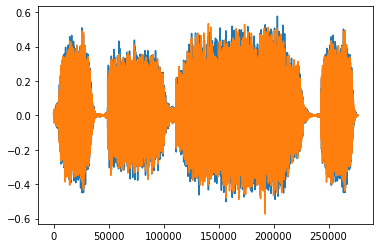

In [10]:
import requests

url = "https://pytorch.org/tutorials//_static/img/steam-train-whistle-daniel_simon-converted-from-mp3.wav"
r = requests.get(url)

with open('steam-train-whistle-daniel_simon-converted-from-mp3.wav', 'wb') as f:
    f.write(r.content)

filename = "steam-train-whistle-daniel_simon-converted-from-mp3.wav"
waveform, sample_rate = torchaudio.load(filename)

print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.figure()
plt.plot(waveform.t().numpy())

Shape of spectrogram: torch.Size([2, 201, 1385])


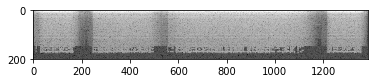

In [11]:
specgram = torchaudio.transforms.Spectrogram()(waveform)

print("Shape of spectrogram: {}".format(specgram.size()))

plt.figure()
plt.imshow(specgram.log2()[0,:,:].numpy(), cmap='gray')

In [13]:
# train_dataset = torchaudio.datasets.LIBRISPEECH("data/librispeech/", url="train-clean-100", download=True)
test_dataset = torchaudio.datasets.LIBRISPEECH("data/librispeech/", url="test-clean", download=True)

In [16]:
# torchaudio.transforms.FrequencyMasking()
# torchaudio.transforms.TimeMasking()

In [17]:

def data_processing(data, data_type="train"):
    spectrograms = []
    labels = []
    input_lengths = []
    label_lengths = []
    for (waveform, _, utterance, _, _, _) in data:
        if data_type == 'train':
            spec = train_audio_transforms(waveform).squeeze(0).transpose(0, 1)
        else:
            spec = valid_audio_transforms(waveform).squeeze(0).transpose(0, 1)
        spectrograms.append(spec)
        label = torch.Tensor(text_transform.text_to_int(utterance.lower()))
        labels.append(label)
        input_lengths.append(spec.shape[0]//2)
        label_lengths.append(len(label))

    spectrograms = nn.utils.rnn.pad_sequence(spectrograms, batch_first=True).unsqueeze(1).transpose(2, 3)
    labels = nn.utils.rnn.pad_sequence(labels, batch_first=True)

    return spectrograms, labels, input_lengths, label_lengths


In [ ]:
from scipy.signal import lfilter, butter
from scipy.io.wavfile import read,write
from numpy import array, int16
import sys

def butter_params(low_freq, high_freq, fs, order=5):
    nyq = 0.5 * fs
    low = low_freq / nyq
    high = high_freq / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, low_freq, high_freq, fs, order=5):
    b, a = butter_params(low_freq, high_freq, fs, order=order)
    y = lfilter(b, a, data)
    return y

if __name__ == '__main__':
    fs,audio = read(sys.argv[1])
    low_freq = 300.0
    high_freq = 3000.0
    filtered_signal = butter_bandpass_filter(audio, low_freq, high_freq, fs, order=6)
    fname = sys.argv[1].split('.wav')[0] + '_moded.wav'
    write(fname,fs,array(filtered_signal,dtype=int16))

In [22]:
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                batch_size=64,
                                shuffle=False)

In [28]:
n = 3
test_dataset[n]

(tensor([[ 3.0518e-05, -9.1553e-05,  2.4414e-04,  ..., -4.3945e-03,
          -4.1199e-03, -1.1292e-03]]),
 16000,
 'THEY THEN RENEWED THEIR JOURNEY AND UNDER THE BETTER LIGHT MADE A SAFE CROSSING OF THE STABLE ROOFS',
 61,
 70970,
 21)

In [ ]:
lowpass_waveform = torchaudio.functional.lowpass_biquad(waveform, sample_rate, cutoff_freq=3000)

print("Min of lowpass_waveform: {}\nMax of lowpass_waveform: {}\nMean of lowpass_waveform: {}".format(lowpass_waveform.min(), lowpass_waveform.max(), lowpass_waveform.mean()))

plt.figure()
plt.plot(lowpass_waveform.t().numpy())